# 1. Setup

In [1]:
import ee
import geemap
import datetime
ee.Initialize()

# 2. Computation

### 2.1. Data Aquistion and Assuption

### 🌦️ Climate Seasons in Kinshasa, DRC

Kinshasa experiences a tropical climate with two distinct seasons:

| **Season**       | **Typical Months**             | **Remarks**                        |
|------------------|-------------------------------|------------------------------------|
| **Wet Season**   | October to May (peak: Nov–Dec) | Heavy rainfall, flooding likely    |
| **Dry Season**   | June to September              | Minimal rainfall, baseline for comparison |

To ensure meaningful flood detection using satellite imagery, we select one representative month from each season:
- **Wet Season Month**: **December**
- **Dry Season Month**: **July**

Source: https://en.wikipedia.org/wiki/Kinshasa 


In [2]:
bbox = [15.14662579020479, -4.489460109907313, 15.681051457462889, -3.956485370168921]
bounds = ee.Geometry.BBox(*bbox)
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')
years = list(range(2016, 2024)) 

### Computing Seasonal Water and Flood Extent

This section describes how seasonal water and flood extent are computed using Sentinel-1 VV band imagery.

### Steps:
- For each defined season (**wet** and **dry**), Sentinel-1 images are filtered over the Area of Interest (`bounds`) using the respective date ranges.
- A **10th percentile composite** of the VV band is created to reduce noise and highlight low backscatter values (typically indicating water).
- A **speckle filter** is applied using a focal mean with a 50-meter square kernel.
- Water is classified using a **threshold** of VV < -15 dB.
- Flooded areas are identified as locations where water is present in the **wet season** but **absent in the dry season**.
- The **flood area is calculated in hectares** using pixel area statistics.

The resulting Earth Engine image includes:
- `flood`: Binary flood mask
- `water`: Seasonal water presence (wet or dry)
- Image properties like `year`, `flood_area`, etc.


In [3]:
def compute_seasonal_water(year):
    """
    Computes seasonal water and flood extent for a given year using Sentinel-1 VV band.

    This function performs the following steps:
    - For each defined season (wet and dry), it filters Sentinel-1 imagery over the AOI (`bounds`)
      for the respective seasonal date range.
    - Computes a 10th percentile composite of the VV band to reduce noise and extract low backscatter values (indicative of water).
    - Applies speckle filtering using focal mean.
    - Classifies water using a threshold (VV < -15 dB).
    - Identifies flooded areas as regions with water in the wet season but not in the dry season.
    - Calculates the flood area in hectares.

    Parameters:
        year (int): The year to compute seasonal water and flood for.

    Returns:
        ee.Image: An Earth Engine image with the following bands and properties:
            - Bands:
                * 'flood': Binary flood mask (1 = flood)
                * 'water': Combined water mask from wet or dry season
            - Properties:
                * 'year': String label of the year
                * 'year_num': Numeric value of the year
                * 'flood_area': Computed flood area in hectares
    """
    season_images = []
    for season in seasons:
        image = (
            s1.filterBounds(bounds)
              .filterDate(f"{year}{season['start']}", f"{year}{season['end']}")
              .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV', 'VH']))
              .select('VV')
        )

        image_min = (
            image.reduce(ee.Reducer.percentile([10]))
                 .clip(bounds)
                 .focal_mean(50, 'square', 'meters')
        )

        water = image_min.lt(-15).toByte().rename(f"water_{season['name']}")
        season_images.append(water)

    water_wet = season_images[0]
    water_dry = season_images[1]
    flood = water_wet.And(water_dry.eq(0)).rename('flood').toByte()
    water_all = water_dry.Or(water_wet).rename('water')

    flood_area = ee.Image.pixelArea().multiply(1e-4).updateMask(flood).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=bounds,
        scale=100,
        maxPixels=1e13
    ).get('area')

    return ee.Image([flood.selfMask(), water_all]).set({
        'year': str(year),
        'year_num': year,
        'flood_area': flood_area
    })


### Flood Frequency Computation
We sum up the binary flood layers (1 for flood, 0 for no flood) for each year,
then divide by the total number of years to get a frequency value between 0 and 1.
A value of 1 means the pixel was flooded every year; 0 means never flooded.

In [4]:
flood_hazard = image_collection.select('flood').sum().divide(len(years))
hazard_vis = {'min': 0, 'max': 1, 'palette': ['white', 'pink', 'red']}

NameError: name 'image_collection' is not defined

### Permanent Water
We mark pixels as "permanent water" if water was detected in **both wet and dry seasons every year**.
Additionally, we exclude any pixels marked as flood hazard (since they change over time).

In [ ]:
permanent_water = image_collection.select('water').reduce(ee.Reducer.allNonZero()).And(flood_hazard.mask().eq(0))

# 3. Visulazation

## 3.1. Plot flood area chart

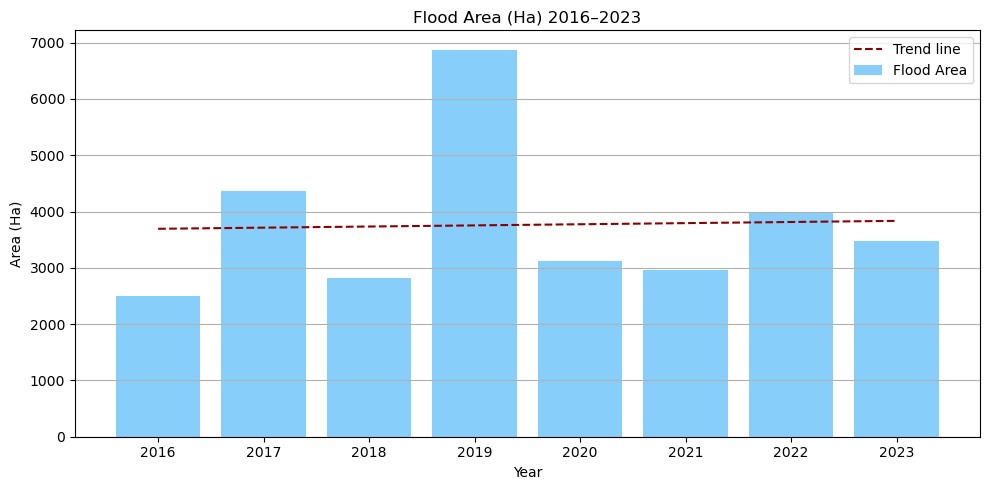

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


flood_stats = image_collection.aggregate_array('flood_area').getInfo()
flood_areas = [round(a, 2) if a else 0 for a in flood_stats]
years_int = [int(y) for y in years]


df = pd.DataFrame({'Year': years_int, 'Flood Area (Ha)': flood_areas})

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(df['Year'], df['Flood Area (Ha)'], color='lightskyblue', label='Flood Area')

# Fit linear regression
z = np.polyfit(df['Year'], df['Flood Area (Ha)'], 1)
p = np.poly1d(z)
ax.plot(df['Year'], p(df['Year']), color='darkred', linestyle='--', label='Trend line')

ax.set_title('Flood Area (Ha) 2016–2023')
ax.set_ylabel('Area (Ha)')
ax.set_xlabel('Year')
ax.grid(axis='y')
ax.legend()

plt.tight_layout()
plt.show()


## 3.2. Display on interactive map

In [36]:
Map = geemap.Map()
Map.centerObject(bounds, 10)
Map.setOptions('HYBRID')


Map.addLayer(flood_hazard, hazard_vis, 'Flood Hazard Index')
Map.addLayer(permanent_water.selfMask(), {'palette': ['blue']}, 'Permanent Water')
Map.addLayer(
    ee.Image().paint(ee.FeatureCollection([ee.Feature(bounds)]), 0, 2),
    {'palette': 'red'}, 'Boundary'
)


for year in years:
    image = compute_seasonal_water(year)
    flood = image.select('flood')
    Map.addLayer(flood.selfMask(), {'palette': 'blue'}, f'Flood {year}')
    Map.layers[-1].visible = False  # hide last-added layer

Map


Map(center=[-4.222957488488352, 15.413838623833445], controls=(WidgetControl(options=['position', 'transparent…

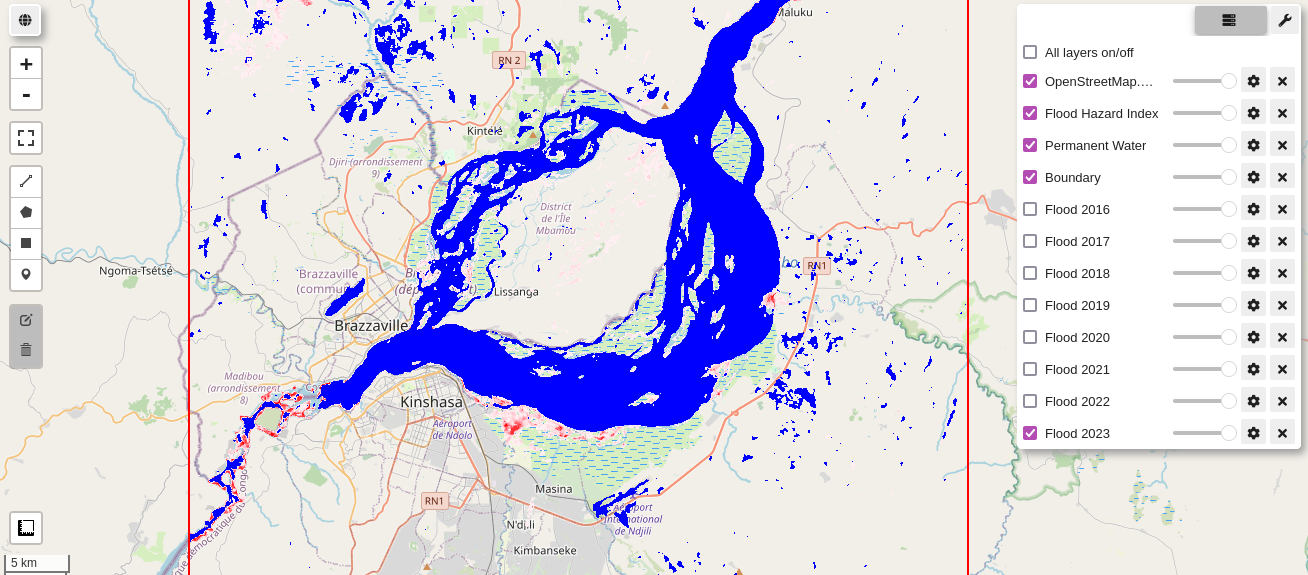

### Export flood hazard map to local GeoTIFF

In [39]:
import os
os.makedirs("data/flood_hazard", exist_ok=True)
geemap.ee_export_image(
    ee_object=flood_hazard,
    filename='data/flood_hazard/hazard.tif',
    scale=30,
    region=bounds,
    file_per_band=False
)

print("✅ flood_hazard exported to data/flood_hazard/hazard.tiff")


Generating URL ...
Please wait ...
Data downloaded to /home/nish/github/konishon/flood_monitoring/notebooks/data/flood_hazard/hazard.tif
✅ flood_hazard exported to data/flood_hazard/hazard.tiff
